# План
1. Графики: Определить общие детали исходных данных 

2. Чистка данных \
2.1. Outliers: посмотреть на выбросы и решить, что с ними делать \
2.2. Ошибки в данных: исправление NaN и возможных ошибок \
**Результат** - модуль features c препроцессингом и генерацией некоторых признаков

3. Анализ: поиск зависимостей в данных с исправлениями

4. Поиск класса людей, которым требуется коммуникация: поможем модели определить самых необходимую группу данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import linear_model, metrics, preprocessing
from sklearn.model_selection import KFold, train_test_split
import xgboost

import azureml.core
from azureml.core import Dataset
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace

import sys
sys.path.append('../')
sys.path.append('../scripts/')

In [2]:
# Log In to Azure ML Workspace
interactive_auth = InteractiveLoginAuthentication(tenant_id="76f90eb1-fb9a-4446-9875-4d323d6455ad")

# Initialise workspace
ws = Workspace.from_config(auth=interactive_auth)

# Data import 
aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
data = aml_dataset.to_pandas_dataframe()
data.set_index('CardHolder', inplace=True)

# Save it to the further opeartions
original_columns = data.columns
data_origin = data.copy()

/anaconda/envs/py37_default/lib/python3.7/site-packages/azureml/dataprep/api/dataflow.py:722: UserWarning: Your pandas and pyarrow versions are incompatible. Please install pyarrow>=0.12.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.12.0 --upgrade
  warnings.warn('Your pandas and pyarrow versions are incompatible. '


In [38]:
# Checkpoint
data = data_origin.copy()

# 1. Графики

In [39]:
def separation_scatter(data_input, columnx, columny, dropx=False, dropy=False):
    data = data_input.copy()
    
    data_mask = np.array([True]*data[columnx].shape[0])
    if (dropx):
        values = data[columnx]
        IQR = values.quantile(0.75) - values.quantile(0.25)
        data_mask = data_mask & (values <= values.quantile(0.75) + IQR * 1.5).values
        
    if (dropy):
        values = data[columny]
        IQR = values.quantile(0.75) - values.quantile(0.25)
        data_mask = data_mask & (values <= values.quantile(0.75) + IQR * 1.5).values
                         
    data = data.loc[data_mask]
    
    fig, ax = plt.subplots(2, 2, figsize=(18, 10))
    plt.title('Признаки: {}, {}'.format(columnx, columny))

    # Data separation (parametres are explicit)
    stubborn = data[data['group'] == 'test']
    stubborn = stubborn[stubborn['response_att'] == 0]

    active = data[data['group'] == 'test']
    active = active[active['response_att'] == 1]

    ax = plt.subplot(221)
    sample = stubborn
    sns.scatterplot(sample[columnx], sample[columny])
    plt.title('Участники тестовой группы, которые не пошли на акцию')
    ax.set_xlabel(columnx)

    plt.subplot(223)
    plt.hist(sample[columny])

    ax = plt.subplot(222)
    sample = active
    sns.scatterplot(sample[columnx], sample[columny])
    plt.title('Участники тестовой группы, которые пошли на акцию')
    ax.set_xlabel(columny)

    plt.subplot(224)
    plt.hist(sample[columny])

    plt.show()

In [73]:
def check_element(data, column, element):
    val_count = (data_origin['stdev_days_between_visits_15d'] == 0).value_counts()
    print("Этот элемент встречается в {}% записей колонки {}".format(100 * val_count[True] / data.shape[0], column))

In [74]:
check_element(data, 'stdev_days_between_visits_15d', 0)

Этот элемент встречается в 76.526755056919% записей колонки stdev_days_between_visits_15d


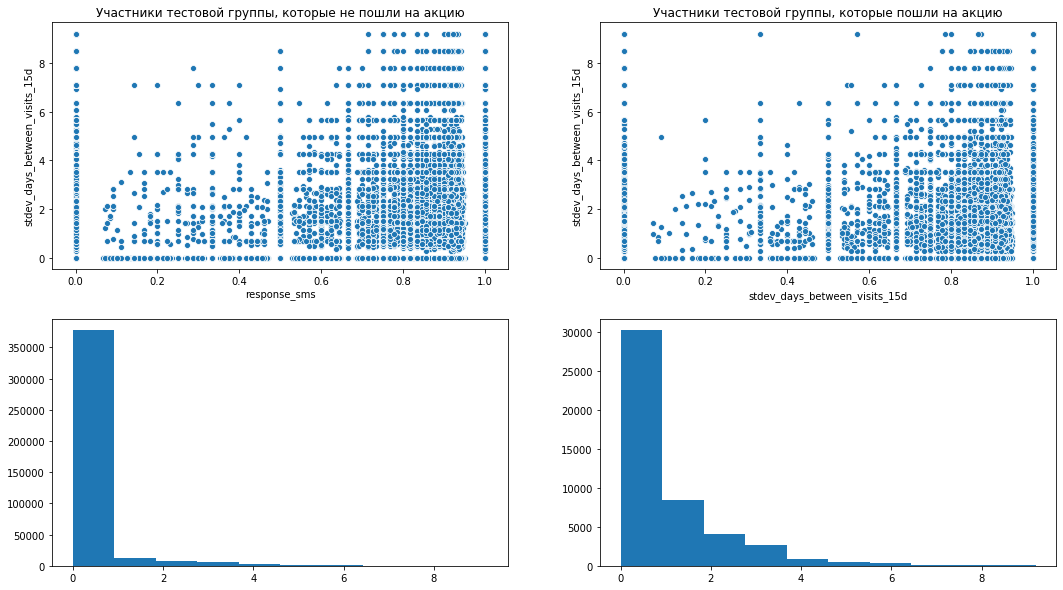

In [50]:
separation_scatter(data, 'response_sms', 'stdev_days_between_visits_15d')

# 2. Чистка данных
## 2.1. Outliers

In [8]:
# Any group number is in diaposon from 20 to 79
all_groups = [i for i in range(20, 80)]

# This function returns columns from 'columns' list, which are met in columns of "data"
def get_columns_list(data, columns):
    return data.columns[data.columns.isin(columns)]

Соберем интересующие нас признаки: некоторые уже есть в датасете, некоторые придется собирать.

In [92]:
data_save = data.copy()

In [93]:
data = data[data['main_format'] == 0]

In [98]:
# Name of a feature : (columns to collect from, method)
# methods : mean, max, min, sum
collect_features = {
    'age'                            : (['age'], 'sum'),
    'response_viber'                 : (['response_viber'], 'max'),
    'response_sms'                   : (['response_sms'], 'max'),
    'promo_share_15d'                : (['promo_share_15d'], 'sum'),
    'k_var_cheque_15d'               : (['k_var_cheque_15d'], 'sum'),
}

# Add collections
for key in collect_features.keys():
    method = collect_features[key][1]
    
    if method == 'mean':
        data.loc[:, key] = data[collect_features[key][0]].mean(axis=1)
    elif method == 'sum':
        data.loc[:, key] = data[collect_features[key][0]].sum(axis=1)
    elif method == 'max':
        data.loc[:, key] = data[collect_features[key][0]].max(axis=1)
    elif method == 'min':
        data.loc[:, key] = data[collect_features[key][0]].min(axis=1)
        
# Additional observations
add_features = ['food_share_15d/1m']
data.loc[:, 'food_share_15d/1m'] = data['food_share_15d'] / (data['food_share_1m'].fillna(0) + 1)
data.loc[:, 'stdev_discount_depth_15d/1m'] = data['stdev_discount_depth_15d' ] / (data['stdev_discount_depth_1m'].fillna(0) + 1)

/anaconda/envs/py37_default/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [99]:
features_list = list(collect_features.keys()) + add_features

In [100]:
def class_separator(data):
    s1 = data[data['group'] == 'test']
    s11 = s1[s1['response_att'] == 1]
    s10 = s1[s1['response_att'] == 0]
    
    s0 = data[data['group'] == 'control']
    s01 = s0[s0['response_att'] == 1]
    s00 = s0[s0['response_att'] == 0]
    
    return s00, s01, s10, s11

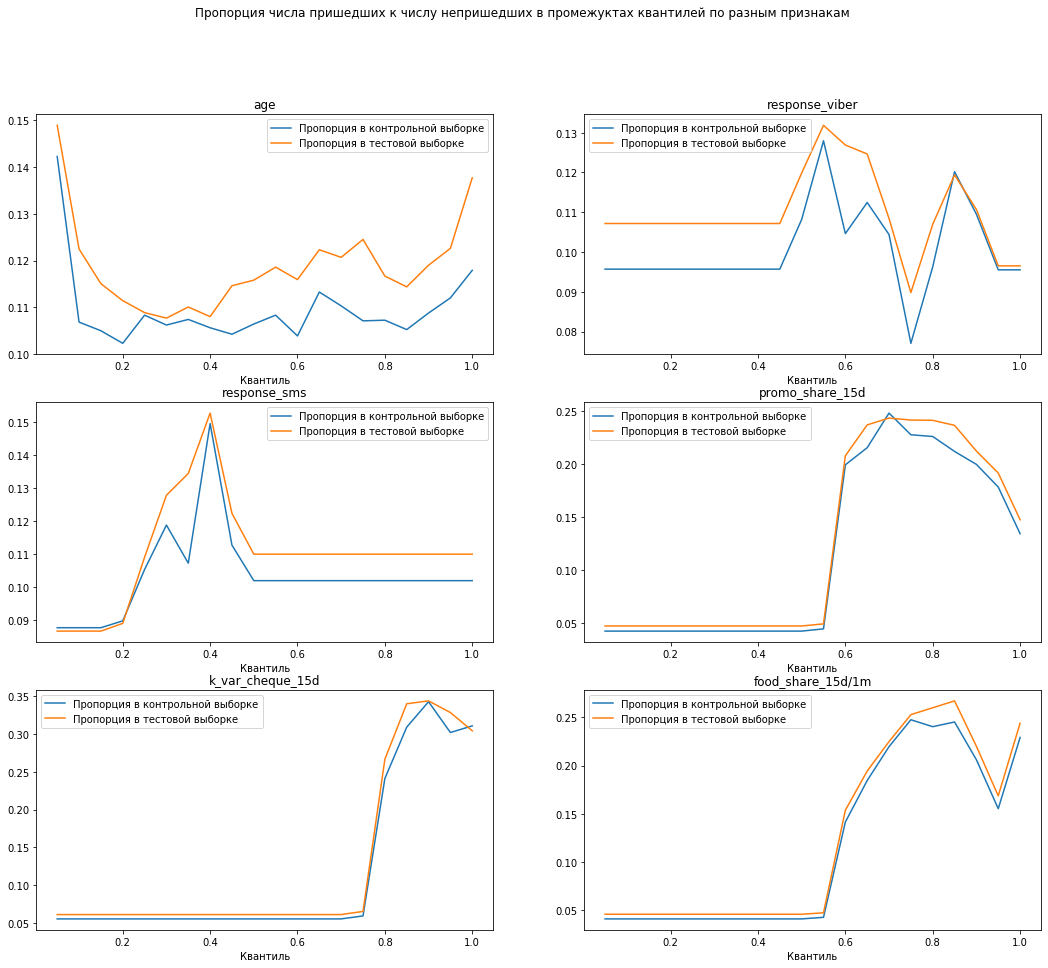

In [101]:
n_groups = 20

fig, ax = plt.subplots(len(features_list)//2, 2, figsize=(18, 5*(len(features_list)//2)))
fig.suptitle('Пропорция числа пришедших к числу непришедших в промежуктах квантилей по разным признакам')

for j in range(len(features_list)):
    key = features_list[j]
    
    sp_control = []
    sp_test = []
    for i in range(n_groups):
        data_sample = data[(data[key] >= data[key].quantile(i * (1 / n_groups))).values
                           & (data[key] <= data[key].quantile((i + 1) * (1 / n_groups))).values]

        s00, s01, s10, s11 = class_separator(data_sample)

        sp_control.append(s01.shape[0] / s00.shape[0])
        sp_test.append(s11.shape[0] / s10.shape[0])

    ax[j//2, j%2].set_xlabel("Квантиль")
    ax[j//2, j%2].plot([(i + 1) * (1 / n_groups) for i in range(n_groups)], sp_control)
    ax[j//2, j%2].plot([(i + 1) * (1 / n_groups) for i in range(n_groups)], sp_test)

    ax[j//2, j%2].legend(['Пропорция в контрольной выборке', 'Пропорция в тестовой выборке'])
    ax[j//2, j%2].set_title(key)
    
plt.show()

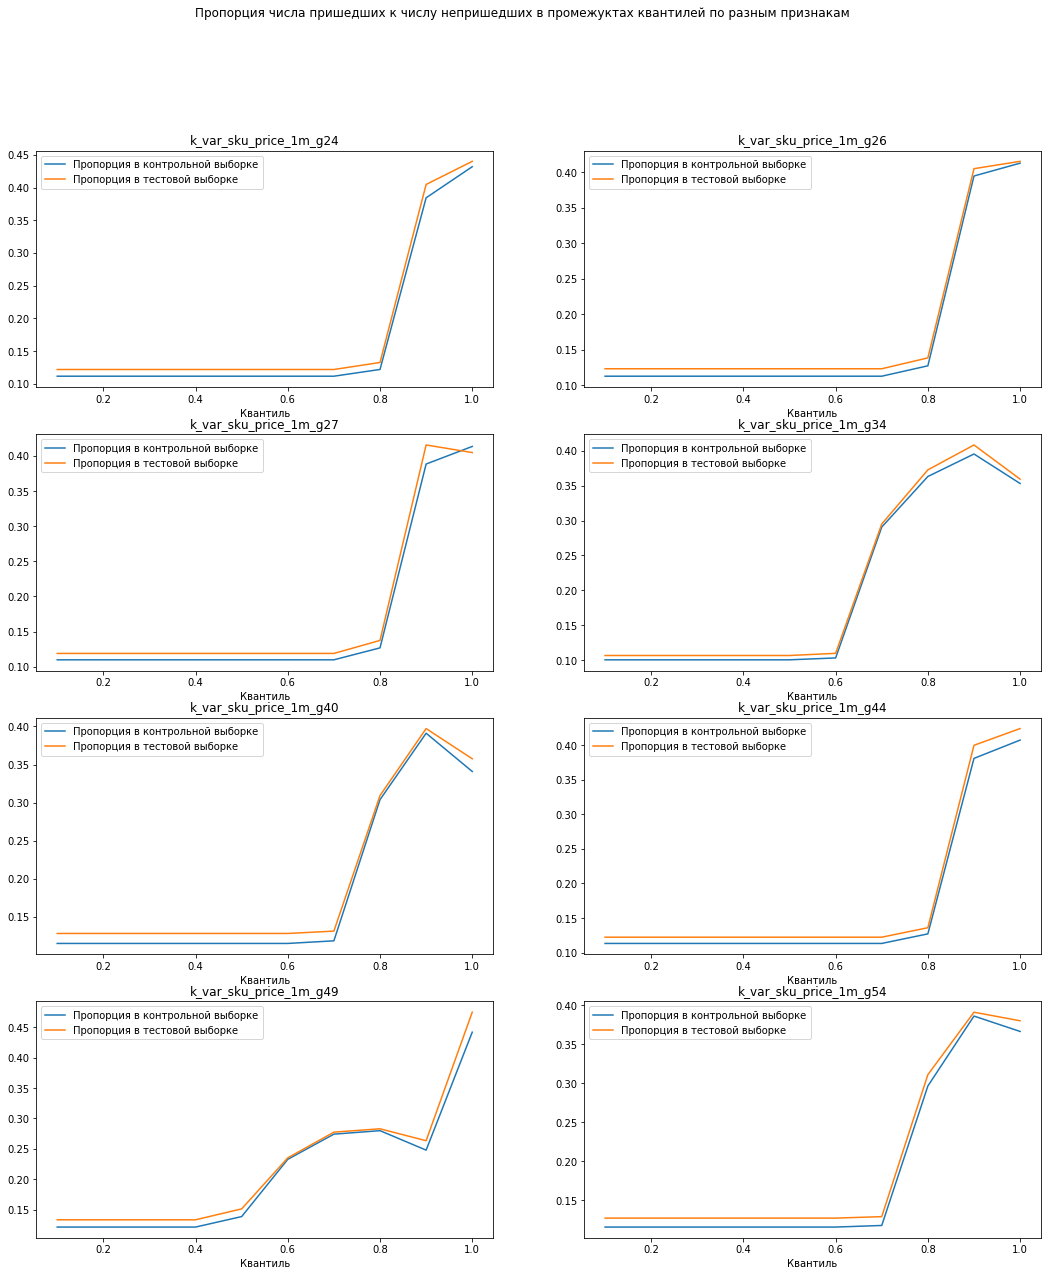

In [102]:
features_list = ["k_var_sku_price_1m_g{}".format(i) for i in 
                 [24, 26, 27, 34, 40, 44, 49, 54]]

n_groups = 10

fig, ax = plt.subplots(len(features_list)//2, 2, figsize=(18, 5*(len(features_list)//2)))
fig.suptitle('Пропорция числа пришедших к числу непришедших в промежуктах квантилей по разным признакам')

for j in range(len(features_list)):
    key = features_list[j]
    
    sp_control = []
    sp_test = []
    for i in range(n_groups):
        data_sample = data[(data[key] >= data[key].quantile(i * (1 / n_groups))).values
                           & (data[key] <= data[key].quantile((i + 1) * (1 / n_groups))).values]

        s00, s01, s10, s11 = class_separator(data_sample)

        sp_control.append(s01.shape[0] / s00.shape[0])
        sp_test.append(s11.shape[0] / s10.shape[0])

    ax[j//2, j%2].set_xlabel("Квантиль")
    ax[j//2, j%2].plot([(i + 1) * (1 / n_groups) for i in range(n_groups)], sp_control)
    ax[j//2, j%2].plot([(i + 1) * (1 / n_groups) for i in range(n_groups)], sp_test)

    ax[j//2, j%2].legend(['Пропорция в контрольной выборке', 'Пропорция в тестовой выборке'])
    ax[j//2, j%2].set_title(key)
    
plt.show()

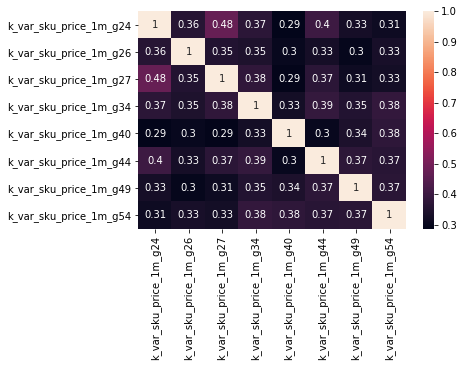

In [103]:
sns.heatmap(data[features_list].corr(), annot=True)
plt.show()

Проверка матрицы корреляции не выявила какой-то особенной связи.

Ни один из проверенных параметров не дал полезного результата: разделяя по выбросам, мы обнаружили, что соотношение людей в тестовой и контрольной группе примерно одно и то же. Отделим выбросы и попытаемся (по whis=1.5) и продолжим поиски. 

In [12]:
# Separation parameter
whis = 1.5

data_map = np.array([])
# Cycle by chosen features
for key in list(collect_features.keys()) + add_features:
    
    # Drop outliers
    IQR = data[key].quantile(0.75) - data[key].quantile(0.25)
    
    if not data_map.size:
        data_map = (data[key] <= data[key].quantile(0.75) + IQR * whis).values
    else:
        data_map = data_map & (data[key] <= data[key].quantile(0.75) + IQR * whis).values
        
data = data[data_map]

## 2.2. Ошибки в данных

In [13]:
data.isna().any(axis=1).value_counts()

True     532384
False       393
dtype: int64

Таких строк очень мало, поэтому придётся как-то заполнять NaN. Если заполнять средними, то это слишком разрежено, поэтому будем заполнять для каждого индекса по-своему. Индекс - это определенные значения колон из "index_columns". Проблема в том, что и них встречаются NaN значения.

In [14]:
print("Чаще всего у покупателя",
      data['children'].value_counts().sort_values(ascending=False).index[0],
      "детей")

Чаще всего у покупателя 0.0 детей


In [15]:
index_columns = ['gender', 'main_format', 'children']

# Let's fill NaN in "index_columns"
data.loc[:, 'group'].replace({'test' : 1, 'control' : 0}, inplace=True)
data.loc[:,'gender'].replace({'М' : 2, 'Ж' : 1, 'Не определен' : 0, None : 0}, inplace=True)
data.loc[:,'children'].replace({None : -1}, inplace=True)

In [16]:
# Calculate percent of records with NaNs
def proportion(series):
    if (series.loc[False] == series.sum()):
        return 0
    return series.loc[True] / series.sum()

dataframe = {'name' : [], 'nans' : []}
for column in data.columns:
    dataframe['name'] += [column]
    dataframe['nans'] += [proportion(data[column].isna().value_counts())]

# Show top 5 by calculated percent
pd.DataFrame(dataframe).sort_values(ascending=False, by='nans')[:5]

,name,nans
120,k_var_sku_price_15d_g49,0.786162
85,k_var_disc_share_15d_g49,0.786042
62,k_var_count_per_cheque_15d_g34,0.736070
119,k_var_sku_price_15d_g34,0.736070
84,k_var_disc_share_15d_g34,0.735981


In [17]:
# Group mean values
group_means = data.groupby(index_columns).mean()
group_means.fillna(group_means.mean(), inplace=True)

for i in group_means.index:
        data.loc[(data['gender'] == i[0]).values &
                 (data['main_format'] == i[1]).values &
                 (data['children'] == i[2]).values] = data.loc[(data['gender'] == i[0]).values &
                     (data['main_format'] == i[1]).values &
                     (data['children'] == i[2]).values].fillna(group_means.loc[i])
        
# Deal with NaN values by groupes
for i in group_means.index:
    data.loc[(data['gender'] == i[0]).values &
             (data['main_format'] == i[1]).values &
             (data['children'] == i[2]).values] = data.loc[(data['gender'] == i[0]).values &
                                                           (data['main_format'] == i[1]).values &
                                                           (data['children'] == i[2]).values].fillna(group_means.loc[i])

# 3. Анализ

In [ ]:
data_granch = 

# 4. Поиск класса людей, которым требуется коммуникация
Общий ход действий такой: создадим побольше интерпретируемых признаков и сделаем вектор значений для каждого человека. После этого найдём всем людям из контрольной группы близжайшего по некоторой метрике партнера. Тогда для каждого человека будем знать его поведение как 1 из 4 классов: \
1) идет на акцию, только если с ним коммуницировать \
2) никогда не ходит на акцию \
3) всегда идет на акцию \
4) идет на акцию, только если с ним не коммуницировать

In [19]:
data = data[original_columns]
data.shape

(532777, 195)

Посмотрим на участников обеих подгрупп с точки зрения их признаков \
1. Сумма продаж товаров из доступных групп за 3 месяца
2. Отклик на предыдущие sms-рассылки

In [ ]:
# from scipy.linalg import svd

sample = data[data['group'] == 1]
sample = sample[sample['response_att']==1].fillna(0).drop('response_att', axis=1)
sample = (sample - data.drop('response_att', axis=1).mean())
U, s, Vh = svd(sample, full_matrices=False)
feature1 = (U @ np.diag(s))[:, 0]
feature2 = (U @ np.diag(s))[:, 1]
sns.scatterplot(feature1, feature2)

sample = data[data['group'] == 1]
sample = sample[sample['response_att']==0].fillna(0).drop('response_att', axis=1)
sample = (sample - data.drop('response_att', axis=1).mean())
U, s, Vh = svd(sample, full_matrices=False)
feature1 = (U @ np.diag(s))[:, 0]
feature2 = (U @ np.diag(s))[:, 1]
sns.scatterplot(feature1, feature2)

plt.show()